<a href="https://colab.research.google.com/github/nyla111/federated-learning-summer-25/blob/main/week3_mix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing Neural Network Families on CIFAR‑10 (CNNs, MLP, MobileNet, ResNet, VGG)

In this notebook, we will:
- Train **several architectures** on **CIFAR‑10**: MLP (fully-connected), a small custom CNN, **ResNet‑18**, **VGG‑style**, and **MobileNetV2**.
- Track and compare metrics: **Top‑1/Top‑5 accuracy**, **macro/micro precision/recall/F1**, **balanced accuracy**, **confusion matrix**, **per‑class accuracy**, **Expected Calibration Error (ECE)** + **reliability diagram**, **inference throughput**, **parameter counts**, and validation **loss**.
- Produce an aggregated **comparison table** and **bar charts** to visualize differences.

> ⚠️ Training several models can be compute‑intensive. Start with **2–3 epochs** for a quick smoke test, then scale to 30–120 epochs for stronger results.

**Requirements**
- Python 3.9–3.13
- `torch`, `torchvision`, `matplotlib`, `tqdm`, `numpy`
- `scikit-learn` (recommended for t‑SNE/metrics; used here for metrics & confusion matrix)

Install if needed:
```bash
pip install torch torchvision matplotlib tqdm numpy scikit-learn



In [ ]:
# PURPOSE: Import libraries, set a reproducible seed, and select device (GPU if available).

import math, random, time
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

try:
    import pandas as pd
    PD_AVAILABLE = True
except Exception:
    PD_AVAILABLE = False

try:
    from sklearn.metrics import (
        confusion_matrix, classification_report,
        precision_recall_fscore_support, balanced_accuracy_score,
        roc_auc_score
    )
    SK_AVAILABLE = True
except Exception:
    SK_AVAILABLE = False
    print("[INFO] scikit-learn not found: advanced metrics will be limited.")

def set_seed(seed: int = 42) -> None:
    """
    Set seeds for Python/NumPy/PyTorch to improve reproducibility.

    Args:
        seed (int): Seed value shared across libraries.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def pick_device(prefer: str = "cuda") -> str:
    """
    Choose compute device string based on availability and preference.

    Args:
        prefer (str): "cuda"/"gpu" or "cpu".

    Returns:
        str: "cuda" if available and requested, else "cpu".
    """
    if prefer.lower() in {"cuda", "gpu"} and torch.cuda.is_available():
        return "cuda"
    return "cpu"

set_seed(42)
device = pick_device("cuda")
print("Using device:", device, "| PyTorch", torch.__version__)


Using device: cuda | PyTorch 2.6.0+cu124


100%|██████████| 170M/170M [00:21<00:00, 7.92MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


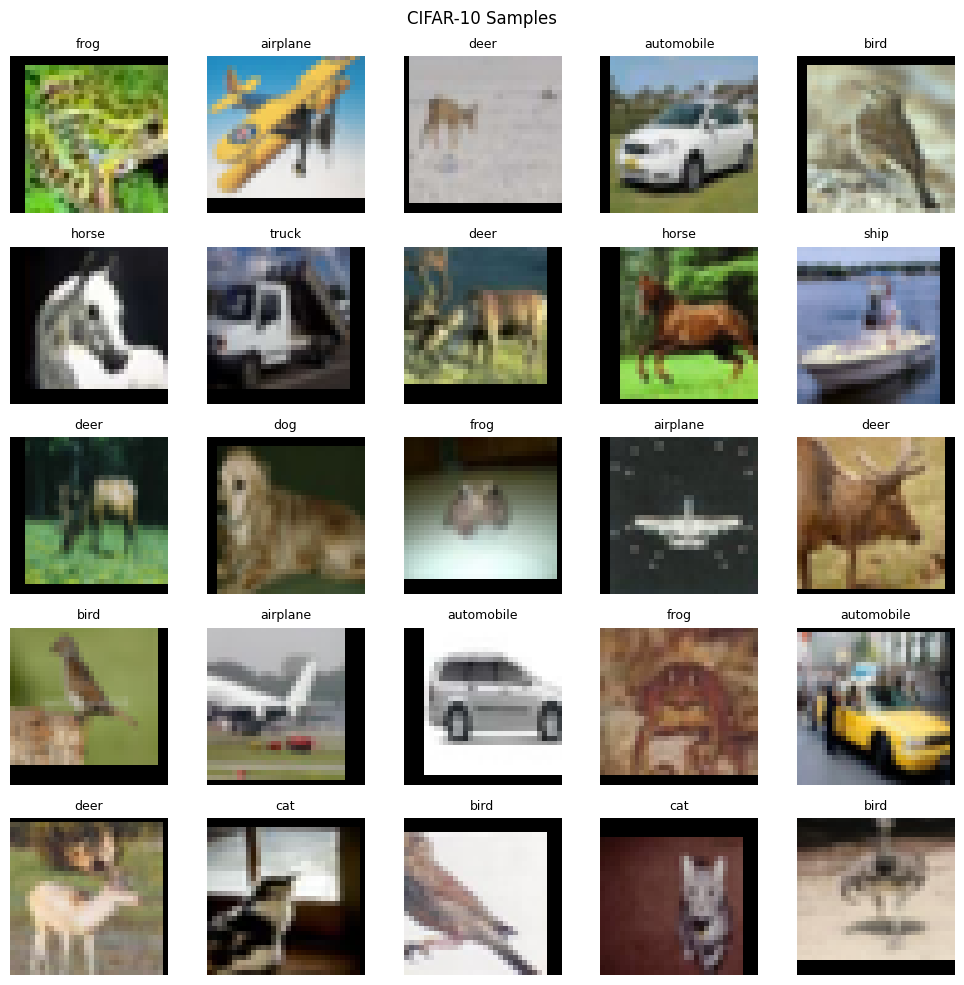

In [ ]:
# PURPOSE: Create CIFAR-10 DataLoaders (with standard augmentations) and visualize a small image grid.

CIFAR10_CLASSES = [
    "airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"
]

def get_cifar10_loaders(batch_size: int = 128, root: str = "./data", augment: bool = True) -> Tuple[DataLoader, DataLoader]:
    """
    Create CIFAR-10 training and validation DataLoaders.

    Args:
        batch_size (int): Batch size for both loaders.
        root (str): Dataset storage path.
        augment (bool): If True, apply common data augmentation to training images.

    Returns:
        (DataLoader, DataLoader): train_loader, val_loader.
    """
    if augment:
        tx_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.248, 0.247, 0.262)),
        ])
    else:
        tx_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.248, 0.247, 0.262)),
        ])

    tx_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.491, 0.482, 0.447), (0.248, 0.247, 0.262)),
    ])

    train_set = datasets.CIFAR10(root, train=True, download=True, transform=tx_train)
    val_set   = datasets.CIFAR10(root, train=False, download=True, transform=tx_test)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader

train_loader, val_loader = get_cifar10_loaders(batch_size=128, augment=True)

def denormalize_cifar(t: torch.Tensor) -> torch.Tensor:
    """
    De-normalize a CIFAR-10 image tensor back to [0,1] for visualization.

    Args:
        t (Tensor): Normalized image tensor of shape (C,H,W).

    Returns:
        Tensor: De-normalized image tensor in [0,1].
    """
    mean = torch.tensor([0.491, 0.482, 0.447]).view(3,1,1)
    std  = torch.tensor([0.248, 0.247, 0.262]).view(3,1,1)
    return (t * std + mean).clamp(0, 1)

def show_batch(loader: DataLoader, n: int = 25) -> None:
    """
    Display a grid of n CIFAR-10 images with labels.

    Args:
        loader (DataLoader): A CIFAR-10 DataLoader that yields (images, labels).
        n (int): Number of images to show.
    """
    imgs, labels = next(iter(loader))
    imgs = imgs[:n].cpu()
    labels = labels[:n].cpu().numpy()
    cols = int(math.sqrt(n))
    rows = int(math.ceil(n/cols))
    plt.figure(figsize=(cols*2.0, rows*2.0))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(denormalize_cifar(imgs[i]).permute(1,2,0))
        plt.title(CIFAR10_CLASSES[labels[i]], fontsize=9)
        plt.axis("off")
    plt.suptitle("CIFAR-10 Samples")
    plt.tight_layout()
    plt.show()

show_batch(train_loader, n=25)

In [ ]:
# PURPOSE: Define multiple architectures with consistent forward interfaces.
# NOTE: VGG here is a CIFAR-friendly variant (1x1 global pooling + compact classifier).

from torchvision.models import resnet18, mobilenet_v2

class MlpCifar(nn.Module):
    """
    Fully-connected MLP for CIFAR-10 (baseline; ignores spatial structure).

    Architecture:
        Flatten(3*32*32) -> Linear(3072->1024) -> ReLU -> Dropout
                          -> Linear(1024->512)  -> ReLU -> Dropout
                          -> Linear(512->10)

    Args:
        hidden1 (int): Units in first hidden layer.
        hidden2 (int): Units in second hidden layer.
        dropout (float): Dropout rate after hidden layers.
        num_classes (int): Number of classes (10).
    """
    def __init__(self, hidden1=1024, hidden2=512, dropout=0.3, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, hidden1), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(hidden2, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class SmallCnnCifar(nn.Module):
    """
    Compact CNN baseline for CIFAR-10.

    Architecture:
        [Conv-BN-ReLU] x3 -> MaxPool -> Dropout
        [Conv-BN-ReLU] x2 -> GlobalAvgPool -> Linear(256->10)
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,128,3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,256,3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(256,256,3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.flatten(1)
        return self.classifier(x)

class CifarResNet18(nn.Module):
    """
    CIFAR-friendly ResNet-18.

    Modifications vs ImageNet ResNet-18:
      - First conv: 3x3 stride=1 padding=1 (instead of 7x7 s=2)
      - Remove initial maxpool
      - Final FC -> num_classes
    """
    def __init__(self, num_classes=10):
        super().__init__()
        m = resnet18(weights=None, num_classes=num_classes)
        m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        m.maxpool = nn.Identity()
        self.net = m

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class CifarVgg16(nn.Module):
    """
    CIFAR-friendly VGG-16 variant:
      - Use VGG-style convolutional blocks
      - Global average pooling to 1x1
      - Compact classifier (Linear 512->10)

    This runs much lighter than ImageNet VGG-16's huge 4096-d FC layers.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        def block(in_ch, out_ch, n):
            layers = []
            for i in range(n):
                layers += [nn.Conv2d(in_ch if i==0 else out_ch, out_ch, 3, padding=1, bias=False),
                           nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)]
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            block(3,   64, 2), nn.MaxPool2d(2),   # 32->16
            block(64, 128, 2), nn.MaxPool2d(2),   # 16->8
            block(128,256, 3), nn.MaxPool2d(2),   # 8->4
            block(256,512, 3), nn.MaxPool2d(2),   # 4->2
            block(512,512, 3), nn.AdaptiveAvgPool2d(1)  # ->1x1
        )
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x).flatten(1)
        return self.classifier(x)

class MobileNetV2Cifar(nn.Module):
    """
    Wrapper for torchvision MobileNetV2 adapted to num_classes=10.

    Notes:
        - MobileNetV2 uses depthwise-separable convolutions; it's parameter-efficient.
        - We replace the final classifier to match CIFAR-10 classes.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        m = mobilenet_v2(weights=None)
        if hasattr(m, "classifier") and isinstance(m.classifier, nn.Sequential):
            in_f = m.classifier[-1].in_features
            m.classifier[-1] = nn.Linear(in_f, num_classes)
        else:
            # Fallback path (older versions)
            m.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(1280, num_classes))
        self.net = m

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


In [ ]:
# PURPOSE: Define metrics utilities & plotting helpers used across models.

@torch.no_grad()
def topk_accuracy(logits: torch.Tensor, targets: torch.Tensor, ks=(1,)) -> Dict[str, float]:
    """
    Compute Top-k accuracy for specified k values.

    Args:
        logits (Tensor): Model outputs (N, C).
        targets (Tensor): Ground truth labels (N,).
        ks (tuple[int]): e.g., (1,5).

    Returns:
        dict: {"top1": float, "top5": float, ...} with values in [0,1].
    """
    maxk = max(ks)
    _, pred = logits.topk(maxk, 1, True, True)  # (N, maxk)
    pred = pred.t()                              # (maxk, N)
    correct = pred.eq(targets.view(1, -1).expand_as(pred))
    out = {}
    for k in ks:
        out[f"top{k}"] = correct[:k].reshape(-1).float().sum().item() / targets.size(0)
    return out

def count_params(model: nn.Module, trainable_only: bool = True) -> int:
    """
    Count number of parameters in a model.

    Args:
        model (nn.Module): PyTorch model.
        trainable_only (bool): Count only parameters with requires_grad=True.

    Returns:
        int: Parameter count.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def expected_calibration_error(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Compute Expected Calibration Error (ECE) with equally spaced confidence bins.

    Args:
        probs (np.ndarray): Class probabilities, shape (N, C).
        labels (np.ndarray): True labels, shape (N,).
        n_bins (int): Number of bins in [0, 1].

    Returns:
        (float, np.ndarray, np.ndarray):
            ECE (scalar), bin_confidence (mean predicted confidence), bin_accuracy (empirical accuracy).
    """
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    accuracies  = (predictions == labels).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    bin_confs, bin_accs = [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (confidences > lo) & (confidences <= hi) if i > 0 else (confidences >= lo) & (confidences <= hi)
        if mask.sum() == 0:
            bin_confs.append(0.0); bin_accs.append(0.0); continue
        conf = confidences[mask].mean()
        acc  = accuracies[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
        bin_confs.append(conf)
        bin_accs.append(acc)
    return float(ece), np.array(bin_confs), np.array(bin_accs)

def plot_reliability(bin_confs: np.ndarray, bin_accs: np.ndarray, title: str = "Reliability Diagram") -> None:
    """
    Plot reliability diagram (confidence vs. accuracy).

    Args:
        bin_confs (np.ndarray): Mean predicted confidence per bin.
        bin_accs  (np.ndarray): Empirical accuracy per bin.
        title (str): Plot title.
    """
    xs = np.linspace(0, 1, len(bin_confs))
    plt.figure(figsize=(5.5,5))
    plt.plot([0,1],[0,1], linestyle="--")  # perfect calibration line
    plt.plot(bin_confs, bin_accs, marker="o")
    plt.xlabel("Confidence"); plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

class History:
    """
    Store training/validation curves.

    Attributes:
        epochs (List[int])
        train_loss, val_loss, train_acc, val_acc (List[float])
    """
    def __init__(self):
        self.epochs = []
        self.train_loss, self.val_loss = [], []
        self.train_acc,  self.val_acc  = [], []

def plot_history(hist: History, title: str = "Learning Curves") -> None:
    """
    Plot loss and accuracy curves from a History object.

    Args:
        hist (History): Metrics history.
        title (str): Title stub for the figure.
    """
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist.epochs, hist.train_loss, label="train loss")
    plt.plot(hist.epochs, hist.val_loss,   label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} — Loss")
    plt.legend(); plt.grid(True); plt.show()

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist.epochs, hist.train_acc, label="train acc")
    plt.plot(hist.epochs, hist.val_acc,   label="val acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} — Accuracy")
    plt.legend(); plt.grid(True); plt.show()

@torch.no_grad()
def benchmark_inference(model: nn.Module, loader: DataLoader, device: str, warmup: int = 2, batches: int = 10) -> float:
    """
    Benchmark inference throughput (images/sec) over a few batches.

    Args:
        model (nn.Module): Model in eval mode.
        loader (DataLoader): Validation loader (no gradient).
        device (str): "cuda" or "cpu".
        warmup (int): Warmup iterations (excluded from timing).
        batches (int): Timed batches to average.

    Returns:
        float: Images per second over timed batches.
    """
    model.eval()
    it = iter(loader)
    # Warmup
    for _ in range(warmup):
        try:
            x, _ = next(it)
        except StopIteration:
            it = iter(loader); x, _ = next(it)
        with torch.inference_mode():
            _ = model(x.to(device))
        if device == "cuda": torch.cuda.synchronize()
    # Timed
    total_imgs, total_time = 0, 0.0
    for _ in range(batches):
        try:
            x, _ = next(it)
        except StopIteration:
            it = iter(loader); x, _ = next(it)
        start = time.time()
        with torch.inference_mode():
            _ = model(x.to(device))
        if device == "cuda": torch.cuda.synchronize()
        total_time += (time.time() - start)
        total_imgs += x.size(0)
    if total_time == 0: return float("nan")
    return total_imgs / total_time


In [ ]:
# PURPOSE: Reusable training/eval with AMP, cosine LR; returns history and predictions/probabilities.

from torch.optim import SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, device: str, scaler: GradScaler) -> Tuple[float, float]:
    """
    Train for a single epoch.

    Args:
        model (nn.Module): Model to train.
        loader (DataLoader): Training loader.
        optimizer (Optimizer): Torch optimizer.
        device (str): "cuda" or "cpu".
        scaler (GradScaler): AMP scaler (enabled on CUDA).

    Returns:
        (float, float): (avg_loss, avg_top1_acc)
    """
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate_full(model: nn.Module, loader: DataLoader, device: str) -> Tuple[float, Dict[str,float], np.ndarray, np.ndarray, np.ndarray]:
    """
    Evaluate on validation set; compute loss, top-k accuracy; collect predictions and probabilities.

    Args:
        model (nn.Module): Evaluated model.
        loader (DataLoader): Validation loader.
        device (str): "cuda" or "cpu".

    Returns:
        (float, metrics_dict, y_true, y_pred, probs):
            - avg_loss: average cross-entropy loss
            - metrics_dict: {"top1": float, "top5": float}
            - y_true (np.ndarray): shape (N,)
            - y_pred (np.ndarray): shape (N,)
            - probs  (np.ndarray): shape (N, C)
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss, total = 0.0, 0
    all_true, all_pred, all_probs = [], [], []
    for x, y in tqdm(loader, desc="Eval ", leave=False):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)
        total += y.size(0)
        probs = F.softmax(logits, dim=1)
        all_true.append(y.cpu().numpy())
        all_pred.append(logits.argmax(dim=1).cpu().numpy())
        all_probs.append(probs.cpu().numpy())
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    probs  = np.concatenate(all_probs)
    # top-k
    ks = topk_accuracy(torch.from_numpy(probs), torch.from_numpy(y_true), ks=(1,5))
    return total_loss/total, ks, y_true, y_pred, probs

def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                device: str, epochs: int = 10, lr: float = 0.1, optimizer_name: str = "sgd") -> Tuple[History, Dict[str, object]]:
    """
    Train with validation per epoch; return history + final evaluation bundle.

    Args:
        model (nn.Module): Model instance (from our zoo).
        train_loader (DataLoader): CIFAR-10 training loader.
        val_loader (DataLoader): CIFAR-10 validation loader.
        device (str): "cuda" or "cpu".
        epochs (int): Training epochs.
        lr (float): Learning rate (SGD works well for ResNet/VGG/MobileNet; try AdamW for MLP).
        optimizer_name (str): "sgd" or "adamw".

    Returns:
        (History, Dict[str, object]):
            - History with curves
            - dict containing:
                {"val_loss": float, "top1": float, "top5": float,
                 "y_true": np.ndarray, "y_pred": np.ndarray, "probs": np.ndarray}
    """
    model = model.to(device)
    scaler = GradScaler(enabled=(device == "cuda"))
    if optimizer_name.lower() == "sgd":
        optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    else:
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    sched = CosineAnnealingLR(optimizer, T_max=epochs)

    hist = History()
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device, scaler)
        val_loss, ks, y_true, y_pred, probs = evaluate_full(model, val_loader, device)
        hist.epochs.append(ep)
        hist.train_loss.append(tr_loss); hist.train_acc.append(tr_acc)
        hist.val_loss.append(val_loss);   hist.val_acc.append(ks["top1"])
        sched.step()
        print(f"Epoch {ep:02d}/{epochs} | train: loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
              f"val: loss={val_loss:.4f}, top1={ks['top1']:.4f}, top5={ks['top5']:.4f}")

    out = {"val_loss": val_loss, "top1": ks["top1"], "top5": ks["top5"],
           "y_true": y_true, "y_pred": y_pred, "probs": probs}
    return hist, out


In [ ]:
# PURPOSE: Register model builders and define a helper to train+evaluate a single model with rich metrics.

def build_model(name: str) -> nn.Module:
    """
    Construct a model by name.

    Args:
        name (str): One of {"mlp","small_cnn","resnet18","vgg16","mobilenet_v2"}.

    Returns:
        nn.Module: Instantiated model set to 10 classes.
    """
    name = name.lower()
    if name == "mlp":
        return MlpCifar()
    if name == "small_cnn":
        return SmallCnnCifar()
    if name == "resnet18":
        return CifarResNet18()
    if name == "vgg16":
        return CifarVgg16()
    if name == "mobilenet_v2":
        return MobileNetV2Cifar()
    raise ValueError(f"Unknown model '{name}'")

def compute_extra_metrics(y_true: np.ndarray, y_pred: np.ndarray, probs: np.ndarray) -> Dict[str, float]:
    """
    Compute a rich set of scalar metrics using scikit-learn if available.

    Args:
        y_true (np.ndarray): Ground-truth labels (N,).
        y_pred (np.ndarray): Predicted labels (N,).
        probs  (np.ndarray): Predicted probabilities (N, C).

    Returns:
        dict: Aggregated metrics (macro/micro precision/recall/F1, balanced accuracy, macro/micro AUC).
    """
    out = {}
    if not SK_AVAILABLE:
        return out
    # Precision/Recall/F1
    for avg in ["macro", "micro", "weighted"]:
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
        out[f"precision_{avg}"] = float(p)
        out[f"recall_{avg}"]    = float(r)
        out[f"f1_{avg}"]        = float(f1)
    # Balanced accuracy
    out["balanced_acc"] = float(balanced_accuracy_score(y_true, y_pred))
    # AUC (one-vs-rest)
    try:
        out["auc_macro_ovr"] = float(roc_auc_score(y_true, probs, multi_class="ovr", average="macro"))
        out["auc_weighted_ovr"] = float(roc_auc_score(y_true, probs, multi_class="ovr", average="weighted"))
    except Exception:
        pass
    return out

def run_single_experiment(
    name: str,
    epochs: int = 5,
    batch_size: int = 128,
    lr: float = 0.1,
    optimizer_name: str = None,
    device: str = device
) -> Dict[str, object]:
    """
    Train one named model and compute an extensive set of metrics.

    Args:
        name (str): Model key.
        epochs (int): Number of training epochs.
        batch_size (int): Minibatch size.
        lr (float): Learning rate.
        optimizer_name (str | None): "sgd" or "adamw". If None, choose automatically by model.
        device (str): "cuda" or "cpu".

    Returns:
        dict: Result bundle including curves, scalar metrics, confusion matrix data, ECE, throughput, param counts.
    """
    # (Re)create loaders (same augmentations for fairness)
    train_loader, val_loader = get_cifar10_loaders(batch_size=batch_size, augment=True)

    # Model & sensible defaults
    model = build_model(name)
    params = count_params(model)
    if optimizer_name is None:
        optimizer_name = "adamw" if name == "mlp" else "sgd"
    lr_use = 1e-3 if name == "mlp" else lr

    # Train
    hist, out = train_model(model, train_loader, val_loader, device=device, epochs=epochs, lr=lr_use, optimizer_name=optimizer_name)

    # Extra metrics
    y_true, y_pred, probs = out["y_true"], out["y_pred"], out["probs"]
    ece, bin_confs, bin_accs = expected_calibration_error(probs, y_true, n_bins=15)
    extras = compute_extra_metrics(y_true, y_pred, probs)

    # Throughput
    tput = benchmark_inference(model, val_loader, device=device, warmup=2, batches=10)

    # Package
    result = {
        "name": name,
        "params": params,
        "val_loss": out["val_loss"],
        "top1": out["top1"],
        "top5": out["top5"],
        "ece": ece,
        "throughput_img_s": tput,
        "history": hist,
        "y_true": y_true,
        "y_pred": y_pred,
        "probs": probs,
        "bin_confs": bin_confs,
        "bin_accs": bin_accs,
    }
    result.update(extras)
    return result


In [ ]:
# PURPOSE: Train several models back-to-back and aggregate metrics into a table and summary plots.
# TIP: Start with epochs=2 for a quick run, then increase to 10–50+ for stronger comparisons.

MODELS_TO_RUN = ["mlp", "small_cnn", "resnet18", "vgg16", "mobilenet_v2"]
EPOCHS = 5          # try 2 first; scale up when you're ready
BATCH_SIZE = 128
LR = 0.1

all_results: List[Dict[str, object]] = []
for name in MODELS_TO_RUN:
    print(f"\n===== Training {name} =====")
    res = run_single_experiment(name, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR)
    all_results.append(res)
    # Plot per-model curves to see dynamics
    plot_history(res["history"], title=f"{name}")

# Build summary table
def as_table(results: List[Dict[str, object]]):
    cols = [
        "name","params","top1","top5","val_loss","precision_macro","recall_macro","f1_macro",
        "balanced_acc","auc_macro_ovr","ece","throughput_img_s"
    ]
    rows = []
    for r in results:
        rows.append([
            r.get("name"),
            r.get("params"),
            round(r.get("top1", float("nan"))*100, 2),
            round(r.get("top5", float("nan"))*100, 2),
            round(r.get("val_loss", float("nan")), 4),
            round(r.get("precision_macro", float("nan")), 4) if "precision_macro" in r else None,
            round(r.get("recall_macro", float("nan")), 4)    if "recall_macro" in r else None,
            round(r.get("f1_macro", float("nan")), 4)        if "f1_macro" in r else None,
            round(r.get("balanced_acc", float("nan")), 4)    if "balanced_acc" in r else None,
            round(r.get("auc_macro_ovr", float("nan")), 4)   if "auc_macro_ovr" in r else None,
            round(r.get("ece", float("nan")), 4),
            round(r.get("throughput_img_s", float("nan")), 1),
        ])
    if PD_AVAILABLE:
        df = pd.DataFrame(rows, columns=cols)
        display(df)
    else:
        print(cols)
        for row in rows:
            print(row)

as_table(all_results)


In [ ]:
# PURPOSE: Visualize key comparisons across models using simple matplotlib bar/line plots.

names = [r["name"] for r in all_results]
top1s = [r["top1"]*100 for r in all_results]
top5s = [r["top5"]*100 for r in all_results]
f1mac = [r.get("f1_macro", float("nan"))*100 if r.get("f1_macro") is not None else float("nan") for r in all_results]
eces  = [r["ece"] for r in all_results]
tputs = [r["throughput_img_s"] for r in all_results]
params= [r["params"] for r in all_results]

def bar(values, title, ylabel):
    plt.figure(figsize=(7,4))
    plt.bar(names, values)
    plt.title(title); plt.ylabel(ylabel); plt.xticks(rotation=20)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

bar(top1s, "Top‑1 Accuracy (%)", "Accuracy (%)")
bar(top5s, "Top‑5 Accuracy (%)", "Accuracy (%)")
bar(f1mac, "Macro F1 (%)", "F1 (%)")
bar(eces,  "Expected Calibration Error (ECE)", "ECE (lower is better)")
bar(tputs, "Inference Throughput (images/sec)", "img/s (higher is better)")

# Params vs Top-1 (log scale on params)
plt.figure(figsize=(6,4))
plt.scatter(params, top1s)
for i, n in enumerate(names):
    plt.annotate(n, (params[i], top1s[i]), textcoords="offset points", xytext=(4,4), fontsize=8)
plt.xscale("log")
plt.xlabel("Parameters (log scale)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Accuracy vs. Parameter Count")
plt.grid(True, which="both")
plt.tight_layout()
plt.show()


In [ ]:
# PURPOSE: For the best Top‑1 model, show confusion matrix, per-class accuracy, and reliability diagram.

# Helper plotting functions
def plot_confusion_matrix(y_true, y_pred, class_names=CIFAR10_CLASSES, normalize=True, title="Confusion Matrix"):
    """
    Plot confusion matrix heatmap.

    Args:
        y_true (array-like): Ground-truth labels.
        y_pred (array-like): Predicted labels.
        class_names (list[str]): Class names for ticks.
        normalize (bool): Normalize rows if True.
        title (str): Title for the plot.
    """
    import numpy as _np
    if SK_AVAILABLE:
        cm = confusion_matrix(y_true, y_pred, labels=_np.arange(len(class_names)))
    else:
        cm = _np.zeros((len(class_names), len(class_names)), dtype=int)
        for t, p in zip(y_true, y_pred): cm[t, p] += 1
    cm = cm.astype(float)
    if normalize:
        cm = cm / (cm.sum(axis=1, keepdims=True)+1e-12)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right", fontsize=8)
    plt.yticks(range(len(class_names)), class_names, fontsize=8)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

def plot_per_class_accuracy(y_true, y_pred, class_names=CIFAR10_CLASSES):
    """
    Bar plot of per-class accuracy.

    Args:
        y_true (array-like): Ground-truth labels.
        y_pred (array-like): Predicted labels.
        class_names (list[str]): Class names.
    """
    import numpy as _np
    y_true = _np.asarray(y_true); y_pred = _np.asarray(y_pred)
    accs = []
    for c in range(len(class_names)):
        idx = (y_true == c)
        correct = (y_pred[idx] == c).sum()
        total = idx.sum()
        accs.append(0.0 if total == 0 else correct/total)
    plt.figure(figsize=(9,4))
    plt.bar(range(len(class_names)), accs)
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right", fontsize=8)
    plt.ylabel("Accuracy"); plt.title("Per-class Accuracy"); plt.tight_layout(); plt.show()

# pick best Top-1
best = max(all_results, key=lambda r: r["top1"])
print("Best model by Top‑1:", best["name"], f"({best['top1']*100:.2f}%)")

plot_confusion_matrix(best["y_true"], best["y_pred"], CIFAR10_CLASSES, normalize=True,
                      title=f"{best['name']} — Confusion Matrix (Normalized)")
plot_per_class_accuracy(best["y_true"], best["y_pred"], CIFAR10_CLASSES)
plot_reliability(best["bin_confs"], best["bin_accs"], title=f"{best['name']} — Reliability Diagram")


In [ ]:
# PURPOSE: Compute macro one-vs-rest ROC-AUC for the best model and print the score.
# ACTION: Optional; requires scikit-learn.

if SK_AVAILABLE:
    try:
        auc_macro = roc_auc_score(best["y_true"], best["probs"], multi_class="ovr", average="macro")
        print(f"Macro ROC‑AUC (OVR) for {best['name']}: {auc_macro:.4f}")
    except Exception as e:
        print("ROC‑AUC not available:", e)
else:
    print("Install scikit-learn to compute ROC‑AUC.")
